The purpose of this notebook is to create the proportions.pickle file which will be of use in the '4. Analysis per cell type' part and also to check (visually via the plots) how cell type proportions change as we vary the proportion of female cells in the dataset.

In [7]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.sparse import vstack

import os
import pickle

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, precision_score
import seaborn as sns

In [8]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

Import data, extract parameters:

In [9]:
path = "C:/Users/NORA/hlca_core.h5ad"
adata = anndata.read_h5ad(path, backed = 'r')

In [10]:
embedding = adata.obsm['X_scanvi_emb']
sex_labels = adata.obs['sex']
individual_labels = adata.obs['donor_id']
cell_type_labels = adata.obs.ann_level_2
classes = sorted(list(set(cell_type_labels)))

In [11]:
with open('helper_pickle_files/color_mappings.pickle', 'rb') as file:
    color_mappings = pickle.load(file)

#### Functions for plotting

In [12]:
def plot_distribution(label_lists, sex_label_lists, title, colors, save = False):
    '''
    Use this for training set distribution.
    '''
    num_props = len(label_lists)
    class_labels = sorted(set(label for labels in label_lists for label in labels))
    num_classes = len(class_labels)

    class_counts = [{label: [0, 0] for label in class_labels} for _ in range(num_props)]

    props = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    label_dict = {f"prop_{props[i]}": {} for i in range(num_props)}

    # calculate class counts for each proportion
    for i, (labels, sex_labels) in enumerate(zip(label_lists, sex_label_lists)):
        for label in class_labels:
            male_count = sum((labels == label) & (sex_labels == 'male'))
            female_count = sum((labels == label) & (sex_labels == 'female'))
            class_counts[i][label] = [male_count, female_count]

            # populate label_dict with counts for each proportion
            label_dict[f"prop_{props[i]}"][label] = (male_count, female_count)

    # plotting
    fig, ax = plt.subplots(figsize=(12, 6))
    bottom = np.zeros(num_props)
    
    for i, label in enumerate(class_labels):
        total_counts = [sum(class_counts[j][label]) for j in range(num_props)]
        ax.bar(np.arange(num_props), total_counts, bottom=bottom, label=label, color=colors[i])
        bottom += total_counts
        
    ax.set_xticks(np.arange(num_props))
    ax.set_xticklabels([f"{float('{:.2f}'.format(prop))}" for prop in np.arange(0, 1.1, 0.1)])
    ax.set_xlabel('Proportion of Female Cells')
    ax.set_ylabel('Count')
    ax.set_title(title)

    handles, labels = ax.get_legend_handles_labels()
    if len(labels) > 55:
        ncol = 3
    elif len(labels) > 30:
        ncol = 2
    else:
        ncol = 1
    ax.legend(reversed(handles), reversed(labels), loc='center left', bbox_to_anchor=(1, 0.5), ncol=ncol)
    
    plt.tight_layout()
    if save:
        plt.savefig(f"{results_path}/training_{title[-1]}.png")
    plt.show()

    # return values
    return label_dict

In [13]:
def plot_grouped_distribution(male_label_list, female_label_list, title, colors, legend = False, save = False):
    '''
    Use this for test set distribution.
    '''
    class_labels = sorted(list(set(male_label_list)))
    num_classes = len(class_labels)

    class_counts = {label: [0, 0] for label in class_labels}

    for label in class_labels:
        male_count = sum((male_label_list == label))
        female_count = sum((female_label_list == label))
        class_counts[label] = [male_count, female_count]

    # Plotting
    fig, ax = plt.subplots(figsize=(4, 6))
    bottom = np.zeros(2)
    
    for i, label in enumerate(class_labels):
        ax.bar([0,1], class_counts[label], bottom=bottom, label=label, color=colors[i])
        bottom += class_counts[label]

    ax.set_xticks([0,1])
    ax.set_xticklabels(['Male', 'Female'])
    ax.set_xlabel('Sex')
    ax.set_ylabel('Count')
    ax.set_title(title)

    handles, labels = ax.get_legend_handles_labels()
    if len(labels) > 55:
        ncol = 3
    elif len(labels) > 15:
        ncol = 2
    else:
        ncol = 1

    if legend:
        ax.legend(reversed(handles), reversed(labels), loc='center left', bbox_to_anchor=(1, 0.5), ncol=ncol)
    
    plt.tight_layout()
    if save:
        plt.savefig(f"{results_path}/test_{title[-1]}.png")
    plt.show()

    return class_counts

#### Train function

In [17]:
def modif_train_clf_and_predict(X, y, sex_labels, proportion_female, classifier='knn', k = 30):
    '''
    Modified train function that does not train or predict, only splits the data.
    '''
    
    np.random.seed(42)
    
    male_indices = np.where(sex_labels == 'male')[0]
    female_indices = np.where(sex_labels == 'female')[0]

    X_male = X[male_indices]
    y_male = y[male_indices]
    X_female = X[female_indices]
    y_female = y[female_indices]
    
    
    X_female_train, X_female_test, y_female_train, y_female_test = train_test_split(
        X_female, y_female, test_size=0.2, stratify=y_female, random_state=42)
    
    # compute what to pass to test_size to get equal test set size to the female set
    male_proportion = len(X_female_test) / len(X_male)

    X_male_train, X_male_test, y_male_train, y_male_test = train_test_split(
        X_male, y_male, test_size=male_proportion, stratify=y_male, random_state=42)
    

    # merge training sets back together
    # X_train = np.concatenate([X_male_train, X_female_train])
    X_train = vstack([X_male_train, X_female_train])
    y_train = np.concatenate([y_male_train, y_female_train])
    sex_labels_train = ['male'] * X_male_train.shape[0] + ['female'] * X_female_train.shape[0]


    # select female cells based on proportion_female
    selected_indices = fixed_select_indices_by_proportion(sex_labels_train, proportion_female)
    X_selected = X_train.tocsr()[selected_indices]
    y_selected = y_train[selected_indices]
    train_sex = np.array(sex_labels_train)[selected_indices]

    return X_selected, y_selected, train_sex, y_female_test, y_male_test

In [22]:
def fixed_select_indices_by_proportion(sex_labels, proportion_female):
    '''
    Selects indices from the training set according to proportion_female. 
    The function calculates a fixed size based on the minimum class in sex_labels.
    It also shuffles the training set so as to not subset from only one part of the array.
    ---------
    
    Parameters:

    sex_labels = training set sex labels; this is the only information needed for index selection
    proportion_female = float denoting desired proportion of female cells
    
    ----------
    
    Returns: an np array containing indices, which can then be used to subset the training set.
    '''
    np.random.seed(42)
    sex_labels_series = pd.Series( (el for el in sex_labels) )
    
    female_indices = np.where(sex_labels_series == 'female')[0]
    male_indices = np.where(sex_labels_series == 'male')[0]
    
    fixed_size = min(len(female_indices), len(male_indices))
    
    np.random.shuffle(female_indices)
    np.random.shuffle(male_indices)

    num_female_cells = int(fixed_size * proportion_female)
    num_male_cells = fixed_size - num_female_cells
        # total will always be fixed_size
        # this works for cases with prop 0% or 100% --> no need to handle them separately
    
    # adjust in case of rounding errors
    num_female_cells = min(num_female_cells, len(female_indices))
    num_male_cells = min(num_male_cells, len(male_indices))

    selected_female_indices = female_indices[:num_female_cells]
    selected_male_indices = male_indices[:num_male_cells]

    return np.concatenate([selected_female_indices, selected_male_indices])

#### Check proportions

ann_level_2 0
ann_level_2 0.1
ann_level_2 0.2
ann_level_2 0.3
ann_level_2 0.4
ann_level_2 0.5
ann_level_2 0.6
ann_level_2 0.7
ann_level_2 0.8
ann_level_2 0.9
ann_level_2 1


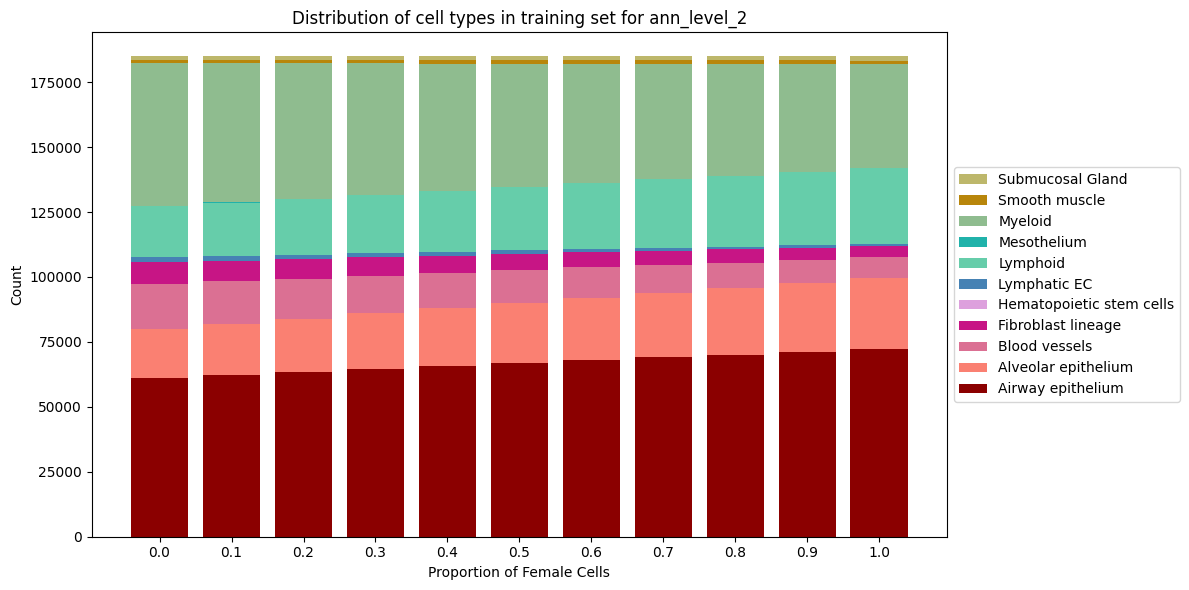

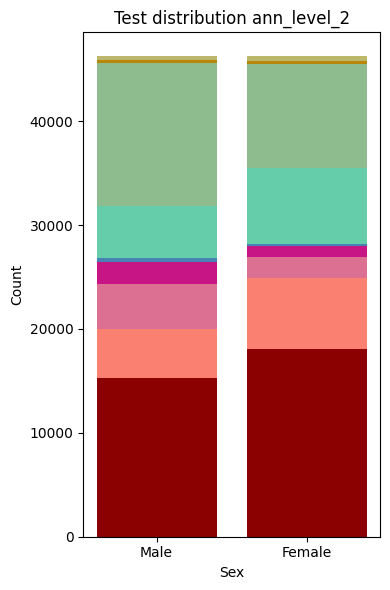

ann_level_3 0
ann_level_3 0.1
ann_level_3 0.2
ann_level_3 0.3
ann_level_3 0.4
ann_level_3 0.5
ann_level_3 0.6
ann_level_3 0.7
ann_level_3 0.8
ann_level_3 0.9
ann_level_3 1


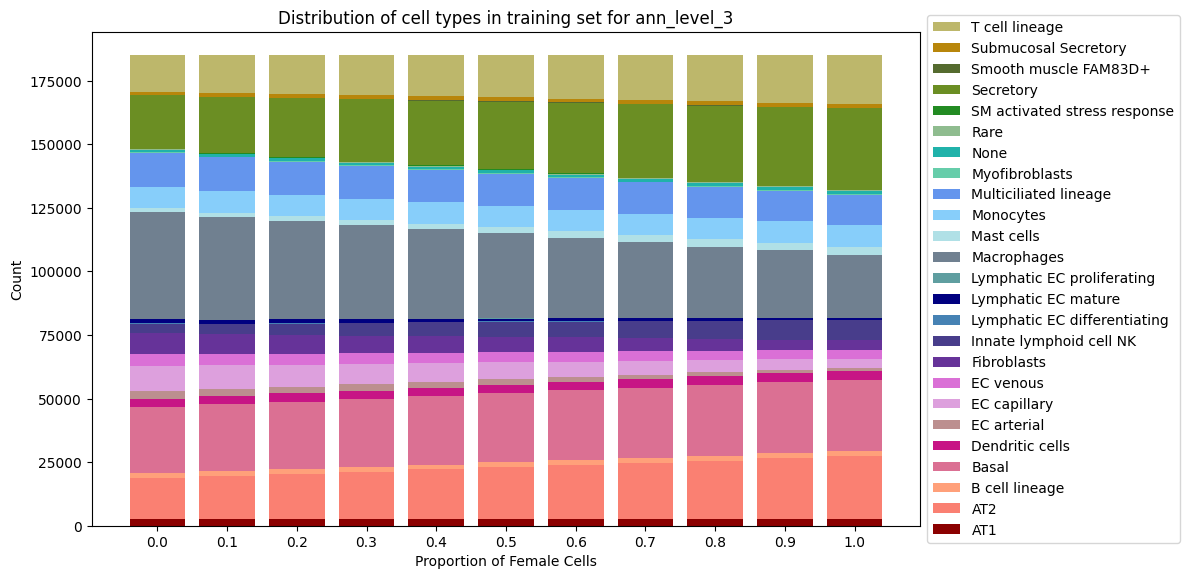

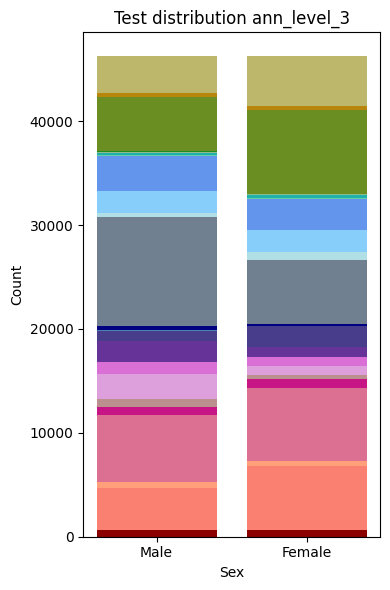

ann_level_4 0
ann_level_4 0.1
ann_level_4 0.2
ann_level_4 0.3
ann_level_4 0.4
ann_level_4 0.5
ann_level_4 0.6
ann_level_4 0.7
ann_level_4 0.8
ann_level_4 0.9
ann_level_4 1


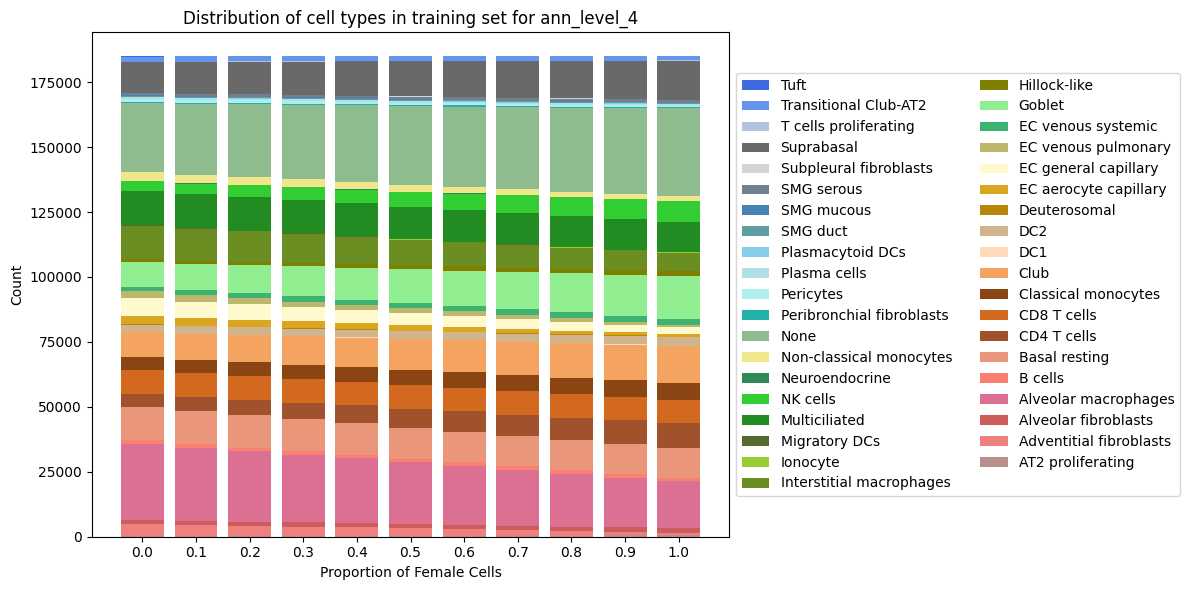

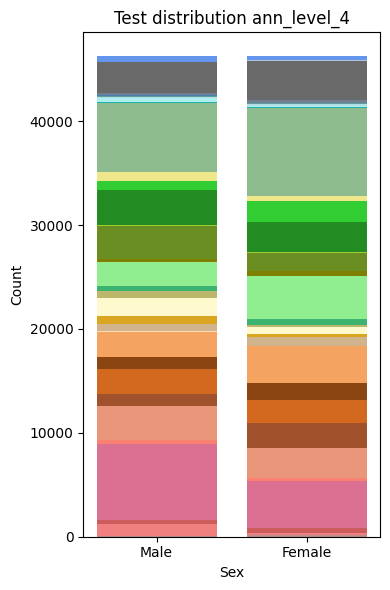

ann_finest_level 0
ann_finest_level 0.1
ann_finest_level 0.2
ann_finest_level 0.3
ann_finest_level 0.4
ann_finest_level 0.5
ann_finest_level 0.6
ann_finest_level 0.7
ann_finest_level 0.8
ann_finest_level 0.9
ann_finest_level 1


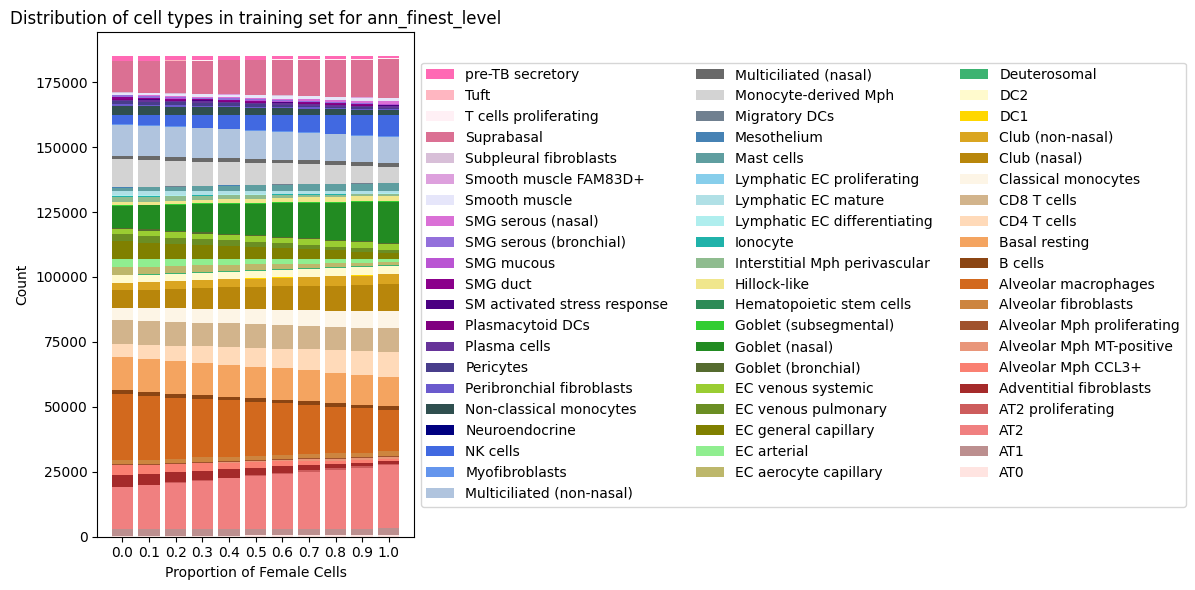

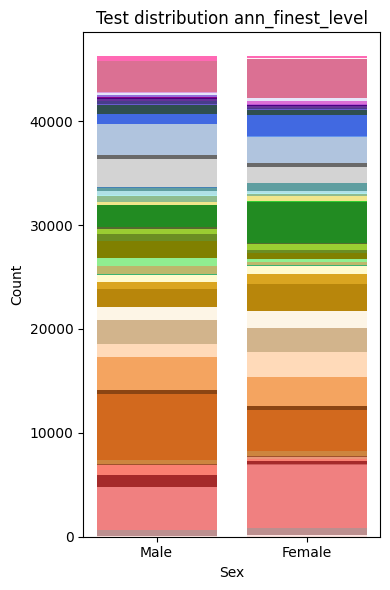

In [23]:
d_array = [] # to store training set counts
t_array = [] # to store test set counts

for i in ['ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_finest_level']:
    embedding = adata.obsm['X_scanvi_emb']
    sex_labels = adata.obs['sex']
    cell_type_labels = adata.obs[i].astype(str)
    classes = sorted(set(cell_type_labels), reverse = True)
    label_lists = []
    sex_label_lists = []
    maletest_lists = []
    femaletest_lists = []

    for prop in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
        print(i, prop)
        X_selected, y_selected, train_sex, y_female_test, y_male_test = modif_train_clf_and_predict(embedding, cell_type_labels, sex_labels, prop)
        label_lists.append(y_selected)
        sex_label_lists.append(train_sex)
        maletest_lists.append(y_male_test)
        femaletest_lists.append(y_female_test)

    if i == 'ann_finest_level':
        d = plot_distribution(label_lists, sex_label_lists, f"Distribution of cell types in training set for {i}", list(color_mappings["ann_finest"].values()))
        t = plot_grouped_distribution(maletest_lists[0], femaletest_lists[0], f"Test distribution {i}", list(color_mappings["ann_finest"].values()))
    else:
        d = plot_distribution(label_lists, sex_label_lists, f"Distribution of cell types in training set for {i}", list(color_mappings[f"ann_{i[-1]}"].values()))
        t = plot_grouped_distribution(maletest_lists[0], femaletest_lists[0], f"Test distribution {i}", list(color_mappings[f"ann_{i[-1]}"].values()))

    # save counts
    d_array.append(d)
    t_array.append(t)

## Export all results

In [28]:
def extract_sexes(test_dict):
    return dict([(key, item[0]) for key, item in test_dict.items()]), dict([(key, item[1]) for key, item in test_dict.items()])

In [29]:
proportions = dict()
proportions["training_sets"] = {"ann_2": d_array[0], "ann_3": d_array[1], "ann_4": d_array[2], "ann_finest": d_array[3]}
proportions["male_test_sets"] = {"ann_2": extract_sexes(t_array[0])[0], "ann_3": extract_sexes(t_array[1])[0], "ann_4": extract_sexes(t_array[2])[0], "ann_finest": extract_sexes(t_array[3])[0]}
proportions["female_test_sets"] = {"ann_2": extract_sexes(t_array[0])[1], "ann_3": extract_sexes(t_array[1])[1], "ann_4": extract_sexes(t_array[2])[1], "ann_finest": extract_sexes(t_array[3])[1]}

with open(f'helper_pickle_files/naive_proportion_dictionary.pickle', 'wb') as file:
    pickle.dump(proportions, file)